# Example queries for Social Characteristics on COVID-19 Knowledge Graph
[Work in progress]

This notebook demonstrates how to run Cypher queries to get [Social Characteristics from the American Community Survey 2018 5-year data](https://data.census.gov/cedsci/table?q=DP02&tid=ACSDP5Y2018.DP02) at multiple levels of geographic granularity. 

Social Characteristics are currently limited to Educational Attainment.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from py2neo import Graph

In [16]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

#### Connect to COVID-19-Net Knowledge Graph

In [17]:
graph = Graph("bolt://132.249.238.185:7687", user="reader", password="demo")

### Educational Attainment
The following characteristics are available for educational attainment. Characteristics ending with Pct are values in percent, whereas all other values are counts. For details see [Subject Definitions](https://www2.census.gov/programs-surveys/acs/tech_docs/subject_definitions/2018_ACSSubjectDefinitions.pdf).

             'DP02_0058E': 'population25YearsAndOver',
             'DP02_0059E': 'lessThan9thGrade',
             'DP02_0059PE': 'lessThan9thGradePct',
             'DP02_0060E': 'grade9thTo12thNoDiploma',
             'DP02_0060PE': 'grade9thTo12thNoDiplomaPct',
             'DP02_0061E': 'highSchoolGraduate',
             'DP02_0061PE': 'highSchoolGraduatePct',
             'DP02_0062E': 'someCollegeNoDegree',
             'DP02_0062PE': 'someCollegeNoDegreePct',
             'DP02_0063E': 'associatesDegree',
             'DP02_0063PE': 'associatesDegreePct',
             'DP02_0064E': 'bachelorsDegree',
             'DP02_0064PE': 'bachelorsDegreePct',
             'DP02_0065E': 'graduateOrProfessionalDegree',
             'DP02_0065PE': 'graduateOrProfessionalDegreePct',
             'DP02_0066E': 'highSchoolGraduateOrHigher',
             'DP02_0066PE': 'highSchoolGraduateOrHigherPct',
             'DP02_0067E': 'bachelorsDegreeOrHigher',
             'DP02_0067PE': 'bachelorsDegreeOrHigherPct',

##### Data are available at multiple levels of geographic granularity
* US County
* US Zip Code
* US Census Tract

### Get Data By US County

If the state and county fips codes are available, social characteristics can be retrieved directly.

Note, fips codes are represented as strings.

##### Example: Highschool and Bachelor's Degrees or higher

In [18]:
state_fips = '06'
county_fips = '073'

In [19]:
query = """
MATCH (e:Education{countyFips:$county_fips, stateFips:$state_fips})
RETURN e.stateFips, e.countyFips, e.population25YearsAndOver, e.highSchoolGraduateOrHigher, e.bachelorsDegreeOrHigher, e.highSchoolGraduateOrHigherPct, e.bachelorsDegreeOrHigherPct
"""
df = graph.run(query, county_fips=county_fips, state_fips=state_fips).to_data_frame()
df.head()

""


Example: Get the same data using relationships

In [6]:
county = 'San Diego County'

In [7]:
query = """
MATCH (a:Admin2{name:$admin2})-[:HAS_SOCIAL_CHARACTERISTICS]-(s:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
RETURN a.name, e.population25YearsAndOver, e.highSchoolGraduateOrHigher, e.bachelorsDegreeOrHigher, e.highSchoolGraduateOrHigherPct, e.bachelorsDegreeOrHigherPct
"""
df = graph.run(query, admin2=county).to_data_frame()
df.head()

,a.name,e.population25YearsAndOver,e.highSchoolGraduateOrHigher,e.bachelorsDegreeOrHigher,e.highSchoolGraduateOrHigherPct,e.bachelorsDegreeOrHigherPct
0,San Diego County,2223376,1937368,848022,87.1,38.1


### Get Data by US Postal Code

Note, postal codes are represented as strings.

In [8]:
zip_code = '92130'

In [9]:
query = """
MATCH (e:Education{postalCode: $zip_code})
RETURN e.postalCode, e.someCollegeNoDegreePct, e.associatesDegreePct, e.bachelorsDegreePct, e.graduateOrProfessionalDegreePct
"""
df = graph.run(query, zip_code=zip_code).to_data_frame()
df.head()

,e.postalCode,e.someCollegeNoDegreePct,e.associatesDegreePct,e.bachelorsDegreePct,e.graduateOrProfessionalDegreePct
0,92130,11.1,3.4,33.4,45.1


##### Example: List educational data for Zip codes with a place name

Note, Zip code areas may cross city boundaries. Place names are the preferred names used by the US Postal Service.

In [10]:
place_name = 'Chula Vista'

query = """
MATCH (p:PostalCode{placeName:$place_name})-[:HAS_SOCIAL_CHARACTERISTICS]-(:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
RETURN p.name AS `Zip code`, 
       e.someCollegeNoDegreePct AS `Some college, no degree`, e.associatesDegreePct AS `Associate's degree`, 
       e.bachelorsDegreePct AS `Bachelor's degree`, e.graduateOrProfessionalDegreePct AS `Graduate or professional degree`
"""
df = graph.run(query, place_name=place_name).to_data_frame()
df.head()

,Zip code,"Some college, no degree",Associate's degree,Bachelor's degree,Graduate or professional degree
0,91910,25.1,8.2,17.2,7.9
1,91911,23.5,7.5,11.2,5.0
2,91913,24.6,10.2,28.8,11.9
3,91914,19.2,11.6,28.6,16.4
4,91915,25.0,12.6,31.1,11.6


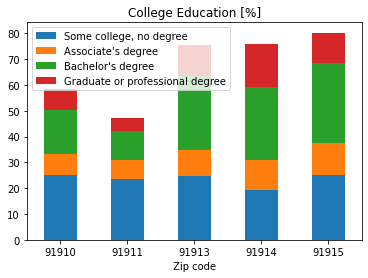

In [11]:
df.plot.bar(x='Zip code', 
            y=["Some college, no degree", "Associate's degree", 
               "Bachelor's degree", "Graduate or professional degree"], 
            title='College Education [%]', stacked=True, rot=0);

### Get Data by US Census Tract

Note, tracts are represented at strings.

##### Example: College degrees for a tract

In [12]:
tract = '06073008324'

In [13]:
query = """
MATCH (e:Education{tract: $tract})
RETURN e.tract, e.someCollegeNoDegreePct, e.associatesDegreePct, e.bachelorsDegreePct, e.graduateOrProfessionalDegreePct
"""
df = graph.run(query, tract=tract).to_data_frame()
df.head()

,e.tract,e.someCollegeNoDegreePct,e.associatesDegreePct,e.bachelorsDegreePct,e.graduateOrProfessionalDegreePct
0,06073008324,15.0,3.3,31.1,42.7


##### Example: List college degrees for all tracts in a county

In [14]:
state = 'California'
county = 'Orange County'

query = """
MATCH (a1:Admin1{name: $admin1})-[:IN]-(a2:Admin2{name: $admin2})-[:IN]-(t:Tract)-[:HAS_SOCIAL_CHARACTERISTICS]-(:SocialCharacteristics)-[:HAS_EDUCATION]-(e:Education)
RETURN a1.name AS State, a2.name AS County, t.name AS Tract,
       e.someCollegeNoDegreePct AS `Some college, no degree`, e.associatesDegreePct AS `Associate's degree`, 
       e.bachelorsDegreePct AS `Bachelor's degree`, e.graduateOrProfessionalDegreePct AS `Graduate or professional degree`
"""
df = graph.run(query, admin1=state, admin2=county).to_data_frame()
df.head()

""
